In [ ]:
##!/usr/bin/env python
"""plot_transect.py

Script plots the HGT vs Longitude cross section as the difference between the two nested domains:
d02: 800m resolution with urban LCZs
d03: 800m resolution where all urban areas are replaced with grass

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Tue Sep  1 14:37:33 AEST 2020

"""

In [1]:
import warnings
warnings.filterwarnings("ignore")

Load Packages

In [2]:
#from __future__ import division
import numpy as np
import pandas as pd
import math
import netCDF4 as nc
import sys
import os
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from matplotlib import cm
from matplotlib.collections import LineCollection
import common_functions as cf
import datetime as dt
import wrf
from scipy import stats
import metpy.calc as mpcalc

### Experimental Details of the Model Data

In [4]:
# Simulation Period
syear = 2017
smon = 1
sday = 2 
eyear = 2017
emon = 2
eday = 28  # Add an extra day so that the 27th Feb data is included
simlen = dt.datetime(eyear,emon,eday) - dt.datetime(syear,smon,sday)
nst = (simlen.days * 24 * 6) # No. simulations days x 24 hours in a day x 6 history intervals per hour

# Dates - Used for subsetting the AWS data so you pick the day before the start date and the day after the end date
sdate = "2017-01-01"
edate = "2017-02-28"

# Data directory 
datadir='/g/data/w97/azh561/WRF/'
ensmem = ['sydney800m','sydney800m_06H','sydney800m_12H','sydney800m_18H','sydney800m_00H']
domain = ["d02","d02","d02","d02","d02"]
nmem = len(ensmem)

# Landsea mask
mask_file='/g/data/w97/azh561/WRF/sydney800m/geo_em.%s.nc' %(domain[0])
f = nc.Dataset(mask_file)
lu = f.variables['LU_INDEX'][0,:,:]
luf = f.variables['LANDUSEF'][0,:,:,:]
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
hgt2d = f.variables['HGT_M'][0,:,:]
lsmask = f.variables['LANDMASK'][0,:,:]
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
nlat,nlon = lon2d.shape
f.close()

#nlev = 44

# LCZs
#LCZnm = ['Compact high-rise','Compact midrise','Compact low-rise','Open high-rise',
#         'Open low-rise','Lightweight low-rise','Large low-rise','Sparsely built','Heavy industry']

# Figure Details
#fig_dir='%s/figures/' %(os.getcwd())
#fig_name_prefix='LCZ_'
##if not os.path.exists(fig_dir):
 # os.makedirs(fig_dir)


In [5]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]
fdates = np.asarray([datelist[x].strftime("%m-%d") for x in range(ntim+1)])[::10]
fhours = np.asarray([datelist[x].strftime("%H") for x in range(ntim+1)])[::10]
fdays = np.asarray([datelist[x].strftime("%m-%d") for x in range(ntim+1)])[::10]

### Define the East-West Transect to look at

In [6]:
i0 = 174 # For d02. If d01 use 114
hgti0 = hgt2d[i0,:]

In [7]:
luma = [None] * len(lu[i0,:])
for ll in range(len(luma)):
    if lu[i0,ll] in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
        luma[ll] = 'l'
    elif lu[i0,ll] == 17:
        luma[ll] = 'o'
    else:
        luma[ll] = 'u'

### Split analysis by heatwave periods

From the Bureau of Meteorology Special Climate Statement 61 there were 3 heatwaves:

    10-14 January
    17-21 January
    31 January - 12 February 
    
For the latter heatwave this was terminated by a cold front.

So here we examine separately the week before the first heatwave, each heatwave period and the week after the third heatwave

If using the Sydney Airport Data as well as Richmond and Observatory Hill (via Scorcher) the dates for the heatwaves are:

    11-14 January
    16-18 January
    30 January - 1 February
    5-7 February
    10-12 February

In [8]:
HW1S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-11 00-00']][0]
HW1F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-14 12-00']][0]

HW2S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-16 00-00']][0]
HW2F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-18 12-00']][0]

HW3S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-30 00-00']][0]
HW3F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-01 12-00']][0]

HW4S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-05 00-00']][0]
HW4F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-07 12-00']][0]

HW5S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-10 00-00']][0]
HW5F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-12 12-00']][0]


### Extract model data corresponding to an East-West Transect through the city (latitude index of 174)


In [ ]:
for mm in range(nmem):
    
    p0 = np.empty((len(ftimes)-1,nlon),dtype=np.float64)
    swd = np.empty((len(ftimes)-1,nlon),dtype=np.float64)# SWDOWN
    lwd = np.empty((len(ftimes)-1,nlon),dtype=np.float64)# GLW
    swu = np.empty((len(ftimes)-1,nlon),dtype=np.float64)# SWNORM 
    lwu = np.empty((len(ftimes)-1,nlon),dtype=np.float64)# OLR TOA outgoing longwave
    pbl = np.empty((len(ftimes)-1,nlon),dtype=np.float64) #PBLH m
    
    # Files list
    filelist = sorted(glob.glob('%s/%s/WRF_output/%s/wrfout_%s_2017-*' %(datadir,ensmem[mm],domain[mm],domain[mm])))
    nfile = len(filelist)
    for ff in range(int(nfile/24)):

        wrffiles = [nc.Dataset(filelist[(ff*24)]),nc.Dataset(filelist[(ff*24)+1]),nc.Dataset(filelist[(ff*24)+2])
        ,nc.Dataset(filelist[(ff*24)+3]),nc.Dataset(filelist[(ff*24)+4]),nc.Dataset(filelist[(ff*24)+5])
        ,nc.Dataset(filelist[(ff*24)+6]),nc.Dataset(filelist[(ff*24)+7]),nc.Dataset(filelist[(ff*24)+8])
        ,nc.Dataset(filelist[(ff*24)+9]),nc.Dataset(filelist[(ff*24)+10]),nc.Dataset(filelist[(ff*24)+11])
        ,nc.Dataset(filelist[(ff*24)+12]),nc.Dataset(filelist[(ff*24)+13]),nc.Dataset(filelist[(ff*24)+14])
        ,nc.Dataset(filelist[(ff*24)+15]),nc.Dataset(filelist[(ff*24)+16]),nc.Dataset(filelist[(ff*24)+17])
        ,nc.Dataset(filelist[(ff*24)+18]),nc.Dataset(filelist[(ff*24)+19]),nc.Dataset(filelist[(ff*24)+20])
        ,nc.Dataset(filelist[(ff*24)+21]),nc.Dataset(filelist[(ff*24)+22]),nc.Dataset(filelist[(ff*24)+23])]

        p0[144*ff:144*(ff+1),:] = wrf.getvar(wrffiles,"PSFC",timeidx=None,method='cat')[:144,i0,:] # Pa
        swd[144*ff:144*(ff+1),:] = wrf.getvar(wrffiles,"SWDOWN",timeidx=None,method='cat')[:144,i0,:] 
        lwd[144*ff:144*(ff+1),:] = wrf.getvar(wrffiles,"GLW",timeidx=None,method='cat')[:144,i0,:] 
        swu[144*ff:144*(ff+1),:] = wrf.getvar(wrffiles,"SWNORM",timeidx=None,method='cat')[:144,i0,:] 
        lwu[144*ff:144*(ff+1),:] = wrf.getvar(wrffiles,"OLR",timeidx=None,method='cat')[:144,i0,:] 
        pbl[144*ff:144*(ff+1),:] = wrf.getvar(wrffiles,"PBLH",timeidx=None,method='cat')[:144,i0,:] # m
         

        for a in range(24):
            wrffiles[a].close()
        
    del filelist,nfile
    
    # Write output to file
        
    dataset = nc.Dataset('/g/data/w97/azh561/WRF/processed/wrfout_East-West_Transect_radiation_%s_%s.nc' %(ensmem[mm],domain[mm]),'w') # open file

    # Create dimensions
    time = dataset.createDimension('time',(len(ftimes)-1))
    lon = dataset.createDimension('lon',nlon)

    # Create coordinate variables
    times = dataset.createVariable('time',ftimes.dtype,('time',))
    longitude = dataset.createVariable('lon',np.float64,('lon',))

    # Create variables
    PSFC = dataset.createVariable('PSFC', np.float64,('time','lon'))
    SWDOWN = dataset.createVariable('SWDOWN', np.float64,('time','lon'))
    GLW = dataset.createVariable('GLW', np.float64,('time','lon'))
    SWNORM = dataset.createVariable('SWNORM', np.float64,('time','lon'))
    OLR = dataset.createVariable('OLR', np.float64,('time','lon'))
    PBLH = dataset.createVariable('PBLH', np.float64,('time','lon'))

    # Write data
    PSFC[:] = p0[:] 
    SWDOWN[:] = swd[:] 
    GLW[:] = lwd[:] 
    SWNORM[:] = swu[:] 
    OLR[:] = lwu[:] 
    PBLH[:] = pbl[:] 
    times[:] = ftimes[:-1]
    longitude[:] = lon2d[i0,:]

    # Write the file
    dataset.close()
    
    del p0,swd,lwd,swu,lwu,pbl

### Read in the extracted data and plot
- calculate the ensemble average on Gadi using ncea

In [9]:
# Get urban
file = nc.Dataset('/g/data/w97/azh561/WRF/processed/wrfout_East-West_Transect_radiation_%s.nc' %('d02'),'r')
PSFC = file.variables['PSFC'][:,:] / 100. # convert to hPa
PBLH = file.variables['PBLH'][:,:]
SWDOWN = file.variables['SWDOWN'][:,:]
GLW = file.variables['GLW'][:,:]
OLR = file.variables['OLR'][:,:]
file.close()


### Plot time series to examine sea breeze and Foehn wind effects

In [10]:
# Function to plot data
def plot_ts(time,tsdata,tind,vlabels,llabel,figurename,lspace):

    """This function plots time series for observations and models"""

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    import string
    import scipy
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=300
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["font.size"] = 18


    # Define dimensions
    nvar = tsdata.shape[0]
    nt = tsdata.shape[1]
    nmod = tsdata.shape[2]
      
    # Create figure object and subplots
    fig, ax = plt.subplots(nvar, 1, figsize=(30.0,5.0*(nvar)), squeeze=False)
    tarr = np.arange(0,nt)
    evenly_spaced_interval = np.linspace(0, 1, nmod)
    mycolors = [plt.cm.coolwarm(x) for x in evenly_spaced_interval]
    
    # Iterate through variables
    for vind in range(nvar):

        for mm in range(nmod):
            ax[vind,0].plot(tarr,tsdata[vind,:,mm], linewidth=1,color=mycolors[mm], linestyle='-',label=llabel[mm])
       
        # Fix Labelling
        ax[vind,0].set_ylabel('%s' %(vlabels[vind]), fontweight = 'bold',fontsize=18)
        ax[vind,0].set_title('(%s)' %(string.ascii_lowercase[vind]), fontweight='bold', fontsize=18, y = 0.9, x = 0.015)
 
        # Amend axis limits
        ax[vind,0].set_xlim(tarr[0],tarr[-1])
              
        if vind < nvar-1:
            ax[vind,0].set_xticks([],[])
        else:
            ax[vind,0].set_xticks(tarr[::lspace])
            ax[vind,0].set_xticklabels(time[::lspace],rotation=90,fontsize=18)
    
        # Add vertical line at dates of interest
        ax[vind,0].axvspan(tind[0], tind[1], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[2], tind[3], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[4], tind[5], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[6], tind[7], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[8], tind[9], alpha=0.25, color='red')

    # Add text to label the heatwaves above the first plot
    ax[0,0].text(0.1875,1.05,'%s HW' %('$1^{st}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.265,1.05,'%s HW' %('$2^{nd}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.515,1.05,'%s HW' %('$3^{rd}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.62,1.05,'%s HW' %('$4^{th}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.705,1.05,'%s HW' %('$5^{th}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
                     
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(figurename,bbox_inches='tight')
#    plt.close(fig)


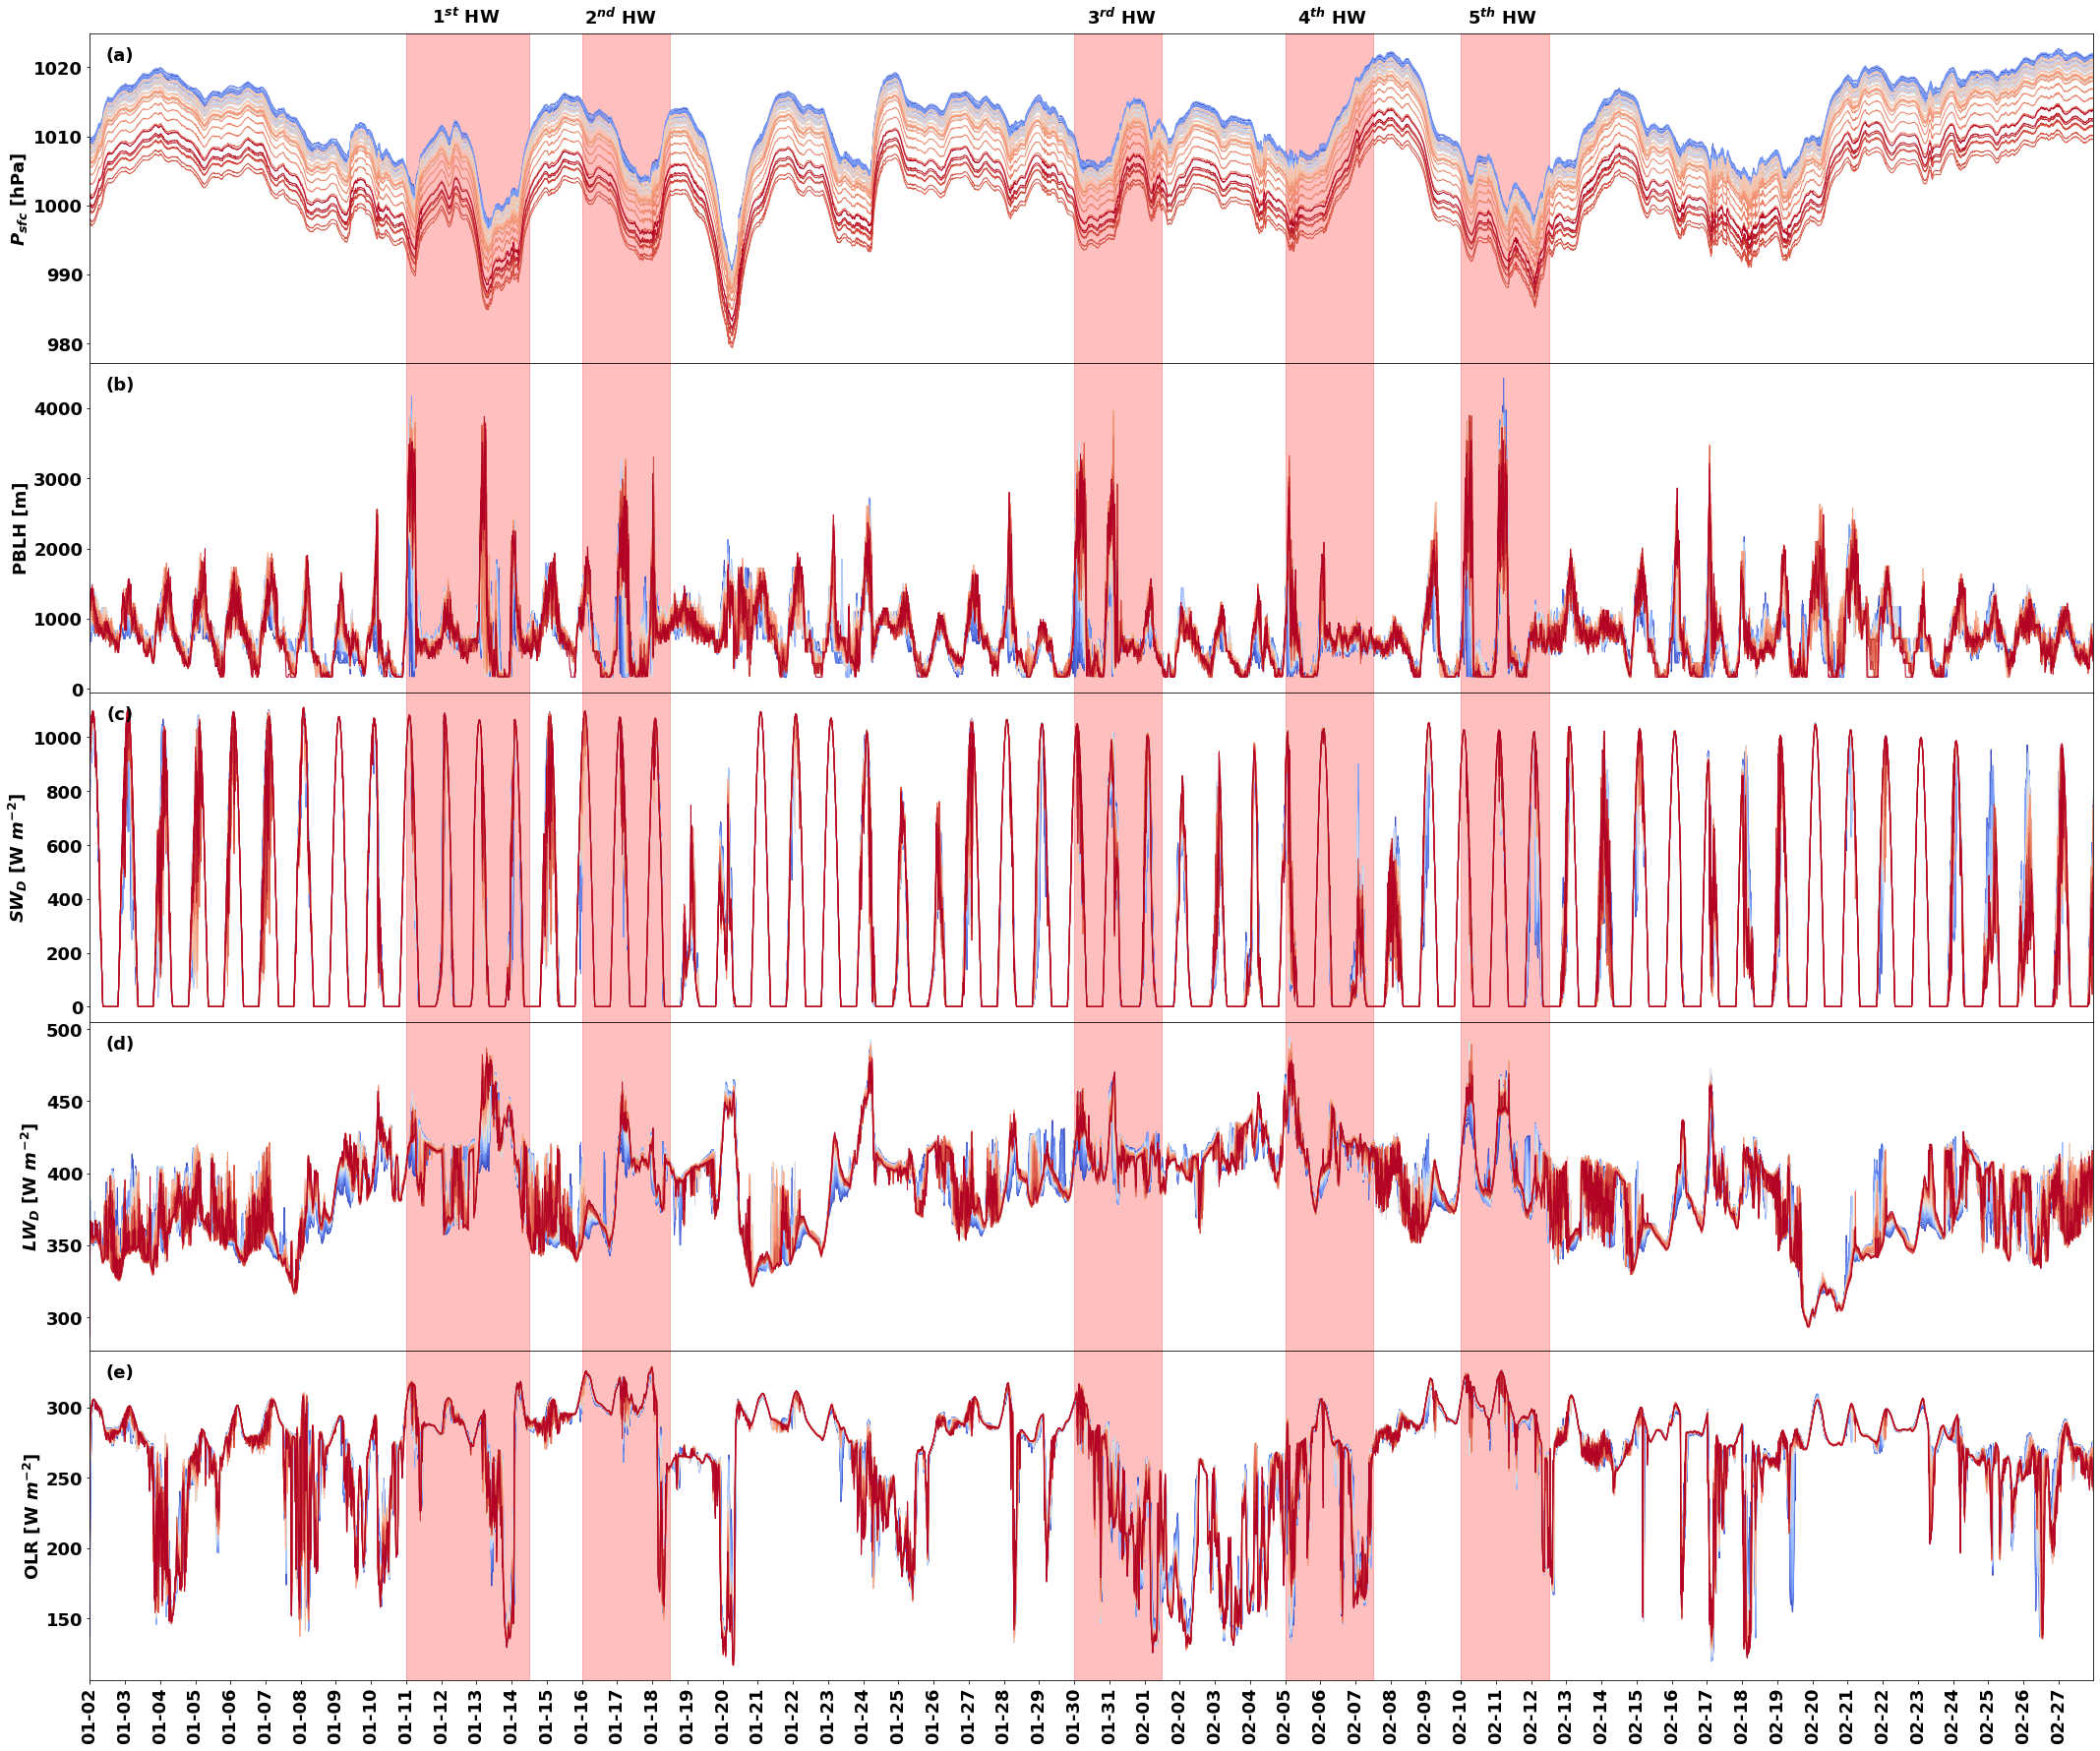

In [11]:
tind = [HW1S,HW1F,HW2S,HW2F,HW3S,HW3F,HW4S,HW4F,HW5S,HW5F]
vlabels = ['$P_{sfc}$ [hPa]','PBLH [m]','$SW_{D}$ [W $m^{-2}$]','$LW_{D}$ [W $m^{-2}$]','OLR [W $m^{-2}$]']
lspace = 144 # As the wrf output is saved at a 10 minute interval
figurename = 'Urban_Lons_Times_Series_Radiation.png'

# Aggregate
tsdata = np.empty((5,len(ftimes)-1,45),dtype=np.float64)
tsdata[0,:,:] = PSFC[:,240:285]
tsdata[1,:,:] = PBLH[:,240:285]
tsdata[2,:,:] = SWDOWN[:,240:285]
tsdata[3,:,:] = GLW[:,240:285]
tsdata[4,:,:] = OLR[:,240:285]


plot_ts(fdates[:-1],tsdata[:,:,::-1],tind,vlabels,lon2d[i0,240:285],figurename,lspace)